In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


# from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.utils import to_categorical


In [10]:
train_dir = "/Users/harry.lopez/Documents/Dataset/archive/Train"
test_dir = "/Users/harry.lopez/Documents/Dataset/archive/Test"

SEED = 12
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 46      #Was 46
EPOCHS = 1
LR =  0.00003
NUM_CLASSES = 14
CLASS_LABELS = ['Abuse','Arrest','Arson','Assault','Burglary','Explosion','Fighting',"Normal",'RoadAccidents','Robbery','Shooting','Shoplifting','Stealing','Vandalism']

In [11]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(
                                   #horizontal_flip=True,
                                   #width_shift_range=0.1,
                                   #height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split=0.2, # set validation split, Added
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  preprocessing_function=preprocess_fun
                                 )

In [12]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                     subset='training',    #Added
                                                    seed = SEED
                                                   )

validation_generator = train_datagen.flow_from_directory(train_dir, # same directory as training data
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset='validation', # set as validation data,  #Added
                                                    seed = SEED
                                                   )
  




test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = SEED
                                                  )

Found 1013081 images belonging to 14 classes.
Found 253264 images belonging to 14 classes.
Found 111308 images belonging to 14 classes.


In [13]:
l2_reg = 0.001

# Initialize model
model = Sequential()

# 1st Conv Layer 
model.add(Conv2D(96, (11,11), input_shape=(IMG_HEIGHT ,IMG_WIDTH,3),
    padding='same', kernel_regularizer=l2(l2_reg)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd Conv Layer 
model.add(Conv2D(256, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd Conv Layer 
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 4th Conv Layer 
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(1024, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

# 5th Conv Layer 
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(1024, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 1st FC Layer
model.add(Flatten())
model.add(Dense(3072))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# 2nd FC Layer
model.add(Dense(4096))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# 3rd FC Layer
model.add(Dense(NUM_CLASSES))
model.add(BatchNormalization())
model.add(Activation('softmax'))

print(model.summary())

model.compile(optimizer=tf.keras.optimizers.SGD(LR), 
                loss='categorical_crossentropy',
                metrics = [tf.keras.metrics.AUC(), tf.keras.metrics.TrueNegatives(),tf.keras.metrics.TruePositives()])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 64, 64, 96)        34944     
                                                                 
 batch_normalization_8 (Batc  (None, 64, 64, 96)       384       
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 64, 64, 96)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 96)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 256)       614656    
                                                                 
 batch_normalization_9 (Batc  (None, 32, 32, 256)     

In [14]:
history = model.fit(x = train_generator,validation_data=validation_generator,epochs = EPOCHS)

22024/22024 [==============================] - 137417s 6s/step - loss: 2.1213 - auc_1: 0.7832 - true_negatives_1: 13166966.0000 - true_positives_1: 43841.0000 - val_loss: 2.5671 - val_auc_1: 0.6001 - val_true_negatives_1: 3292432.0000 - val_true_positives_1: 14060.0000


2420/2420 [==============================] - 2848s 1s/step
ROC AUC score: 0.47879187264675127


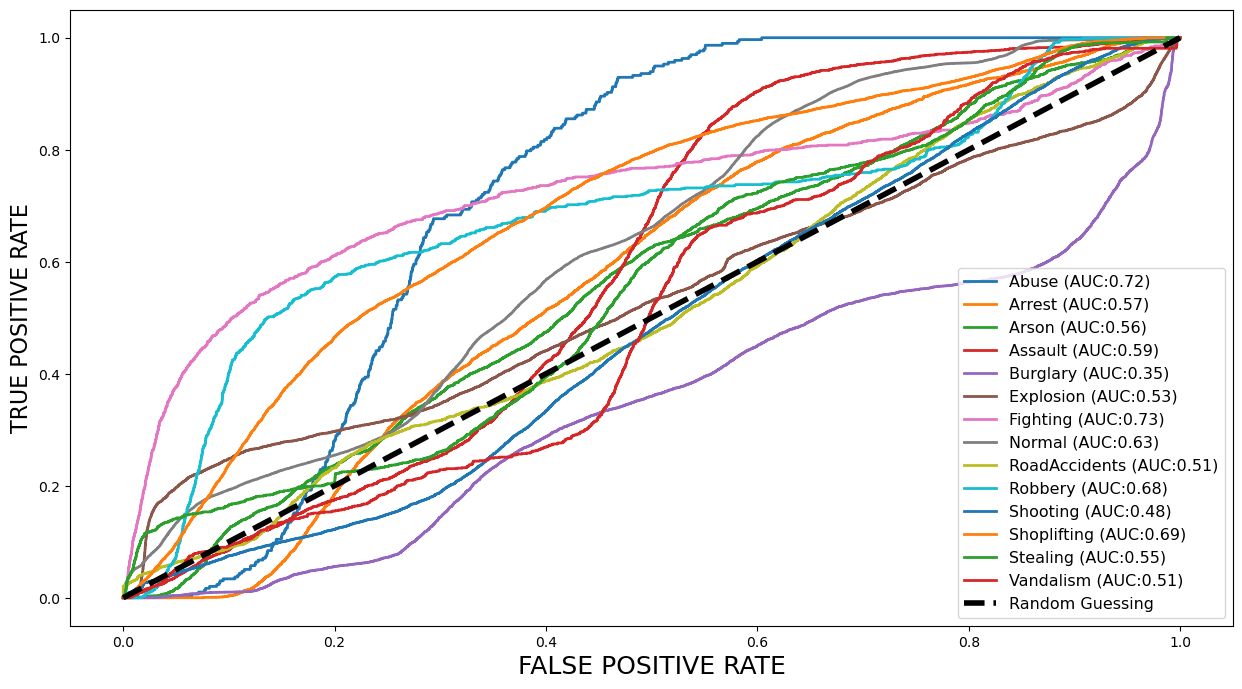

In [16]:
preds = model.predict(test_generator)
y_test = test_generator.classes
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [15]:
model.save('/Users/harry.lopez/Documents/Python/Models/Test.Alexnet.h5')